### Importing required libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### 1. Data Loading and Preprocessing


In [ ]:
IMG_HEIGHT, IMG_WIDTH = 128, 128
IMAGE_DIR = rf"./dataset/face_crop"
MASK_DIR = rf"./dataset/face_crop_segmentation"

## **Data Loading and Preprocessing**  
1. **Sorting & Loading**: Images and masks are read and sorted.  
2. **Resizing**: Each image and mask is resized to **(128, 128)**.  
3. **Normalization**:  
   - Images are converted to RGB and scaled between **[0,1]**.  
   - Masks are grayscale, expanded to **single-channel**, and normalized.  
4. **Dataset Size**: Only **1000 images** are loaded to optimize training time.  

In [4]:
def load_data(image_dir, mask_dir, img_size=(IMG_HEIGHT, IMG_WIDTH)):
    images, masks = [], []
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))
    count = 0
    for img_file, mask_file in zip(image_files, mask_files):
        if(count >= 1000):
            break
        img = cv2.imread(os.path.join(image_dir, img_file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size) / 255.0
        mask = cv2.imread(os.path.join(mask_dir, mask_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, img_size)
        mask = np.expand_dims(mask, axis=-1) 
        mask = mask / 255.0
        images.append(img)
        masks.append(mask)
        count+=1
    return np.array(images), np.array(masks)

X, Y = load_data(IMAGE_DIR, MASK_DIR)

In [5]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

## **Model Architecture & Training**  

### **U-Net Model**  
A U-Net architecture is used with **Batch Normalization** and **Dropout (0.3)** to enhance training stability. The model starts with **64 filters**, doubling at each downsampling step and halving during upsampling.

### **Loss & Metrics**  
- **Loss Function**: Dice loss, which improves segmentation performance.  
- **Evaluation Metrics**: IoU and Dice Score to assess segmentation accuracy.  

### **Training**  
- **Optimizer**: Adam (learning rate = 1e-3).  
- **Dataset**: Due to compute constraints, training was done on **1000 images**.  
- **Validation Performance**:  
  - **IoU**: 0.8432  
  - **Dice Score**: 0.9079  


In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

START_FILTERS = 64  
DROPOUT_RATE = 0.3  
LEARNING_RATE = 1e-3  
BATCH_SIZE = 16
EPOCHS = 50

def unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), start_filters=START_FILTERS, dropout_rate=DROPOUT_RATE):
    inputs = Input(input_shape)

    
    f = start_filters  
    c1 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(dropout_rate)(c1)
    c1 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    f *= 2
    c2 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(dropout_rate)(c2)
    c2 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    f *= 2
    c3 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(dropout_rate)(c3)
    c3 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    f *= 2
    c4 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(dropout_rate)(c4)
    c4 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    
    f *= 2
    c5 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(dropout_rate)(c5)
    c5 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    
    f //= 2
    u6 = UpSampling2D((2, 2))(c5)
    u6 = Concatenate()([u6, c4])
    c6 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(dropout_rate)(c6)
    c6 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    f //= 2
    u7 = UpSampling2D((2, 2))(c6)
    u7 = Concatenate()([u7, c3])
    c7 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(dropout_rate)(c7)
    c7 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    f //= 2
    u8 = UpSampling2D((2, 2))(c7)
    u8 = Concatenate()([u8, c2])
    c8 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(dropout_rate)(c8)
    c8 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)

    f //= 2
    u9 = UpSampling2D((2, 2))(c8)
    u9 = Concatenate()([u9, c1])
    c9 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(dropout_rate)(c9)
    c9 = Conv2D(f, (3, 3), activation='leaky_relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs, outputs)
    return model


def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + 1e-7)

def dice_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)


def dice_loss(y_true, y_pred, smooth=1e-6):
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_coef = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice_coef


def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce + d_loss


model = unet()
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=dice_loss, metrics=[iou_metric, dice_metric])
history = model.fit(X_train, Y_train,validation_data=(X_val, Y_val),batch_size=BATCH_SIZE,epochs=EPOCHS)
model.save("final-128.h5")


Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 222ms/step - dice_metric: 0.6366 - iou_metric: 0.4796 - loss: 0.3699 - val_dice_metric: 0.6483 - val_iou_metric: 0.4800 - val_loss: 0.3508
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - dice_metric: 0.8094 - iou_metric: 0.6805 - loss: 0.1925 - val_dice_metric: 0.7087 - val_iou_metric: 0.5492 - val_loss: 0.2902
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - dice_metric: 0.8254 - iou_metric: 0.7040 - loss: 0.1757 - val_dice_metric: 0.7395 - val_iou_metric: 0.5872 - val_loss: 0.2608
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - dice_metric: 0.8439 - iou_metric: 0.7311 - loss: 0.1570 - val_dice_metric: 0.5384 - val_iou_metric: 0.3688 - val_loss: 0.4601
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - dice_metric: 0.8664 - iou_metric: 0.7649 - loss: 0.1343 - val_dice_metric: 0.5448 - val_iou_metric: 0.3748 - val_loss: 0.4542
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - dice_metric: 0.8622 - iou_metric: 0.7585 - lo

## **Post-Processing of Predicted Masks**  

The predicted masks are refined using **morphological closing** (7×7 kernel) to remove small gaps and **Gaussian blur** (3×3) to smooth edges. This improves mask quality by reducing noise and enhancing segmentation accuracy.  


In [7]:
import cv2
import numpy as np

def post_process_mask(preds, kernel_size=7, blur_size=3):
    is_single = False
    if preds.ndim == 3: 
        preds = np.expand_dims(preds, axis=0)
        is_single = True

    processed_preds = []
    for i in range(preds.shape[0]):
        mask = (preds[i, :, :, 0] > 0.5).astype(np.uint8)
        kernel = np.ones((kernel_size, kernel_size), np.uint8)
        closed_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        blurred_mask = cv2.GaussianBlur(closed_mask.astype(np.float32), (blur_size, blur_size), 0)
        blurred_mask = np.clip(blurred_mask, 0, 1)
        processed_preds.append(blurred_mask)
    result = np.array(processed_preds)
    if is_single:
        return result[0] 
    return result 

## **Model Evaluation using IoU and Dice Score**

This section evaluates the U-Net model's segmentation performance using **IoU** and **Dice Score** without **post-processing**.

### **IoU and Dice Calculation**
- **IoU (`calculate_iou`)**: Measures the overlap between predicted and ground truth masks as **Intersection / Union**.
- **Dice Score (`calculate_dice`)**: Computes segmentation similarity using **(2 × Intersection) / (Total pixels in both masks)**.


#### Iou and Dice on Training + Validation Dataset without post-processing

In [ ]:
def calculate_iou(y_true, y_pred, threshold=0.5):
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)
    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()
    if union == 0:
        return 1.0 
    return intersection / union

def calculate_dice(y_true, y_pred, threshold=0.5):
    if y_true.dtype != np.bool_:
        y_true = y_true.astype(bool)
    if y_pred.dtype != np.bool_:
        y_pred = (y_pred > threshold).astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()
    if total == 0:
        return 1.0
    return 2 * intersection / total

y_preds = model.predict(X)
iou_scores = []
dice_scores = []
for i in range(len(Y)):
    iou = calculate_iou(Y[i], y_preds[i])
    dice = calculate_dice(Y[i], y_preds[i])
    iou_scores.append(iou)
    dice_scores.append(dice)
    # print(f"Image {i+1}: IoU = {iou:.4f}")
    # print(f"Image {i+1}: Dice = {dice:.4f}")

mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
print(f"\nMean IoU on Training + Validation Dataset: {mean_iou:.4f}")
print(f"\nMean Dice on Training + Validation Dataset: {mean_dice:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step

Mean IoU on Training + Validation Dataset: 0.8158

Mean Dice on Training + Validation Dataset: 0.8934


#### Iou and Dice on  Validation Dataset without post-processing

In [9]:
y_preds = model.predict(X_val)
iou_scores = []
dice_scores = []
for i in range(len(Y_val)):
    iou = calculate_iou(Y_val[i], y_preds[i])
    dice = calculate_dice(Y_val[i], y_preds[i])
    iou_scores.append(iou)
    dice_scores.append(dice)
    # print(f"Image {i+1}: IoU = {iou:.4f}")
    # print(f"Image {i+1}: Dice = {dice:.4f}")

mean_iou = np.mean(iou_scores)
mean_dice = np.mean(dice_scores)
print(f"\nMean IoU on Validation Dataset: {mean_iou:.4f}")
print(f"\nMean Dice on Validation Dataset: {mean_dice:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

Mean IoU on Validation Dataset: 0.7951

Mean Dice on Validation Dataset: 0.8804


### This section evaluates the U-Net model's segmentation performance using **IoU** and **Dice Score** after **post-processing**.

In [23]:
import numpy as np

def ensure_same_shape(y_true, y_pred):
    if y_true.ndim == 3 and y_true.shape[-1] == 1:
        y_true = np.squeeze(y_true, axis=-1)
    if y_pred.ndim == 3 and y_pred.shape[-1] == 1:
        y_pred = np.squeeze(y_pred, axis=-1)
    return y_true, y_pred


def calculate_iou(y_true, y_pred, threshold=0.5):
    y_true, y_pred = ensure_same_shape(y_true, y_pred)
    y_true = (y_true > 0.5).astype(np.float32)
    y_pred = (y_pred > threshold).astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    intersection = max(intersection, 0)
    union = max(union, 1e-7)
    iou = intersection / union
    return iou


def calculate_dice(y_true, y_pred, threshold=0.5):
    y_true, y_pred = ensure_same_shape(y_true, y_pred)
    y_true = (y_true > 0.5).astype(np.float32)
    y_pred = (y_pred > threshold).astype(np.float32)
    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    intersection = max(intersection, 0)
    union = max(union, 1e-7)
    dice = (2.0 * intersection) / union
    return dice

#### Iou and Dice on Training + Validation Dataset after post-processing

In [28]:
y_preds = model.predict(X)
smoothed_preds = post_process_mask(y_preds)
iou_scores = []
dice_scores = []

for i in range(len(Y)):
    iou = calculate_iou(Y[i], smoothed_preds[i])
    dice = calculate_dice(Y[i], smoothed_preds[i])
    
    iou_scores.append(iou)
    dice_scores.append(dice)

avg_iou = np.mean(iou_scores)
avg_dice = np.mean(dice_scores)

print(f"Average IoU on Training + Validation Dataset: {avg_iou:.4f}")
print(f"Average Dice on Training + Validation Dataset: {avg_dice:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step
Average IoU on Training + Validation Dataset: 0.8845
Average Dice on Training + Validation Dataset: 0.9335


#### Iou and Dice on Validation Dataset after post-processing

In [35]:
y_preds = model.predict(X_val)
smoothed_preds = post_process_mask(y_preds)
iou_scores = []
dice_scores = []

for i in range(len(Y_val)):
    iou = calculate_iou(Y_val[i], smoothed_preds[i])
    dice = calculate_dice(Y_val[i], smoothed_preds[i])
    iou_scores.append(iou)
    dice_scores.append(dice)

avg_iou = np.mean(iou_scores)
avg_dice = np.mean(dice_scores)

print(f"Average IoU on Validation Dataset: {avg_iou:.4f}")
print(f"Average Dice on Validation Dataset: {avg_dice:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Average IoU on Validation Dataset: 0.8432
Average Dice on Validation Dataset: 0.9079


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


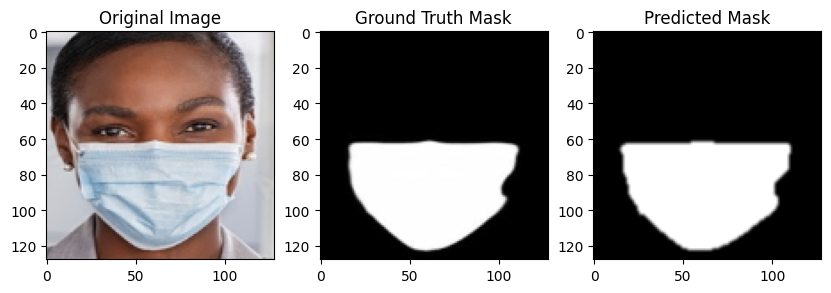

In [22]:
def predict_sample(model, X_val, Y_val, index=54):
    pred_mask = model.predict(np.expand_dims(X_val[index], axis=0))[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    pred_mask = post_process_mask(pred_mask)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val[index])
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(Y_val[index].squeeze(), cmap="gray")
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask.squeeze(), cmap="gray")
    plt.title("Predicted Mask")
    plt.show()
predict_sample(model, X_val, Y_val)

In [36]:
idx = np.argmin(iou_scores)
idx1 = np.argmin(dice_scores)
idx==idx1

True

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


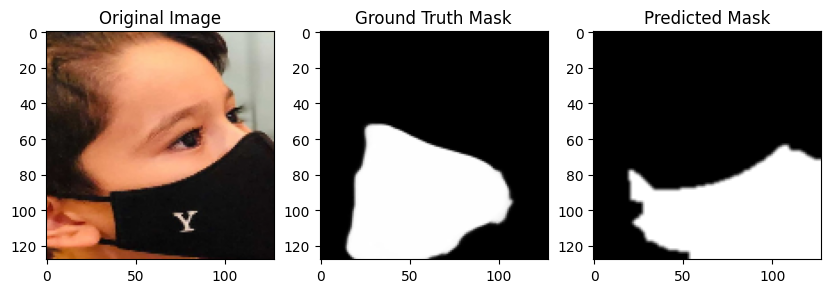

In [37]:
predict_sample(model, X_val, Y_val,idx)


In [39]:
idxmx = np.argmax(iou_scores)
idx1mx = np.argmax(dice_scores)
idxmx==idx1mx

True

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


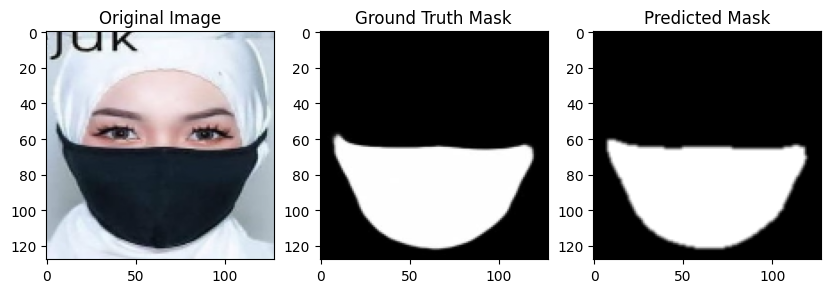

In [40]:
predict_sample(model, X_val, Y_val,idx1mx)
